# Deep Learning: Classifying for Sources

In this notebook we work through a simple example for a Neural Network using TensorFlow and the Keras interface. Initially we will start with a vanila network with two hidden layers and then expand this to a convolutional neural network with drop out layers and batch normalization

In [1]:
# to reduce the deprecation warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from astroML.utils import split_samples
from tensorflow.keras.utils import to_categorical
%matplotlib inline

<img src="figures/fig_neural_network-1.png">

<img src="figures/fig_morph_nn-1.pdf">

### Loading some visualization and helper functions

In [3]:
np.set_printoptions(precision=2)

def normalize_image(image):
    '''Rescale a stamp for CNN'''
    sigmaG_coeff =  0.7413
    image = image.reshape(21,21)
    
    per25,per50,per75 = np.percentile(image,[25,50,75])
    sigmaG = sigmaG_coeff * (per75 - per25)
    image[image<(per50-2*sigmaG)] = per50-2*sigmaG
    image -= np.min(image)
    image /= np.sum(image)
    
    return image
    
def plot_image_array(images, nrows=2, ncols=5, figsize=[8,4], nx=21, ny=21, title=''):
    '''Plot an array of images'''
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
    fig.subplots_adjust(hspace=0, left=0.07, right=0.95, wspace=0.05, bottom=0.15)
    for indx in np.arange(nrows*ncols):
        i = int(indx/ncols)
        j = indx%ncols
        if (i == 0):
            ax[i][j].xaxis.set_major_formatter(plt.NullFormatter())
        if (j != 0):
            ax[i][j].yaxis.set_major_formatter(plt.NullFormatter())

        ax[i][j].imshow(images[indx].reshape(nx,ny), cmap='gray')

    ax[0][int(ncols/2)].set_title(title)
    ax[0][0].set_ylabel('$y$')
    ax[nrows-1][int(ncols/2)].set_xlabel('$x$')            
    
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, 
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


### Load the training samples and create test and validation data sets

In [4]:
import numpy as np
import matplotlib.pyplot as plt

#read in source and noise images
path = './'
rand_state = np.random.RandomState(777)
sources = np.load(path+'data/stamps_sources.npz')
noise = np.load(path+'data/stamps_noise.npz')

point_source_stamps = []
for image in sources['data']:
    point_source_stamps.append(normalize_image(image))

no_point_source_stamps = []
for image in noise['data']:
    no_point_source_stamps.append(normalize_image(image))

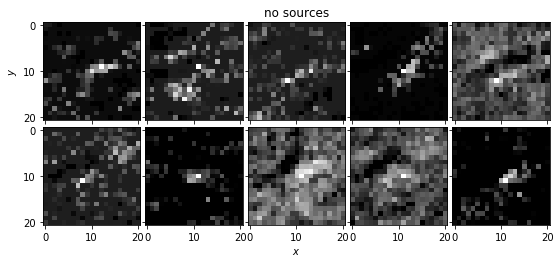

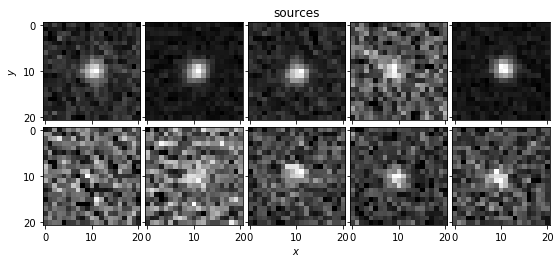

In [5]:
#plot sample of images
plot_image_array(no_point_source_stamps, title='no sources')
plot_image_array(point_source_stamps, title='sources')

### Create a training, validation, and test sample

We will use astroML's split_samples to do this

In [6]:
def reshape_arrays(data, labels):
    '''reshape arrays for Keras'''
    data = data.reshape(-1,21, 21, 1) 
    labels = to_categorical(labels)
    return data,labels

input_stamps = np.vstack([no_point_source_stamps, point_source_stamps])
stamp_class = np.zeros(len(no_point_source_stamps) + len(point_source_stamps))
stamp_class[len(no_point_source_stamps):] = 1

(data_train, data_val, data_test), (class_train, class_val, class_test) = split_samples(input_stamps, stamp_class, 
                                                                                        [0.7,0.2,0.1])
data_train, class_train = reshape_arrays(data_train, class_train)
data_val, class_val = reshape_arrays(data_val, class_val)
data_test, class_test = reshape_arrays(data_test, class_test)

print ('Number of samples in the training ({}); test ({}); and validation ({}) data sets'.format(data_train.shape[0], 
                                                                                    data_test.shape[0],
                                                                                   data_val.shape[0]))

Number of samples in the training (42000); test (6000); and validation (12000) data sets


## Create a Neural Network

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

import numpy as np
def simple(input_shape=(21, 21, 1), n_classes: int = 2):

    model = tf.keras.models.Sequential(name='simple')
    # input: 21x21 images with 1 channel -> (21, 21, 1) tensors.
    # this applies 16 convolution filters of size 3x3 each.
    model.add(tf.keras.layers.Dense(30, input_shape=input_shape, activation='relu', name='fc_1'))
    
    model.add(tf.keras.layers.Dense(30, activation='relu', name='fc_2'))

    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_1'))

    model.add(tf.keras.layers.Flatten())
    # output layer
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))

    return model

In [10]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11338174901801161216, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3968166697301851239
 physical_device_desc: "device: XLA_CPU device"]

In [11]:
simple_model = simple()
simple_model.summary()

Model: "simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_1 (Dense)                 (None, 21, 21, 30)        60        
_________________________________________________________________
fc_2 (Dense)                 (None, 21, 21, 30)        930       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 21, 21, 30)        120       
_________________________________________________________________
flatten (Flatten)            (None, 13230)             0         
_________________________________________________________________
fc_out (Dense)               (None, 2)                 26462     
Total params: 27,572
Trainable params: 27,512
Non-trainable params: 60
_________________________________________________________________


In [ ]:
simple_model = simple()
n_epochs=5
simple_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
simple_model_history = simple_model.fit(data_train, class_train, epochs=n_epochs, batch_size=1, verbose=1, 
                                        validation_data=(data_val, class_val), shuffle=True)

Train on 42000 samples, validate on 12000 samples
Epoch 1/5
13179/42000 [========>.....................] - ETA: 28:02 - loss: 0.2413 - accuracy: 0.9110

In [10]:
simple_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
simple_model_history = simple_model.fit(data_train, class_train, epochs=n_epochs, batch_size=256, verbose=1, 
                                        validation_data=(data_val, class_val), shuffle=True)
classes = simple_model.predict(data_test)

Train on 42000 samples, validate on 12000 samples
Epoch 1/5
42000/42000 [==============================] - 50s 1ms/sample - loss: 0.6861 - accuracy: 0.7398 - val_loss: 0.6921 - val_accuracy: 0.5037
Epoch 2/5
42000/42000 [==============================] - 46s 1ms/sample - loss: 0.6692 - accuracy: 0.8395 - val_loss: 0.6873 - val_accuracy: 0.5311
Epoch 3/5
42000/42000 [==============================] - 48s 1ms/sample - loss: 0.6416 - accuracy: 0.8436 - val_loss: 0.6664 - val_accuracy: 0.6743
Epoch 4/5
42000/42000 [==============================] - 49s 1ms/sample - loss: 0.5929 - accuracy: 0.8491 - val_loss: 0.5986 - val_accuracy: 0.7933
Epoch 5/5
42000/42000 [==============================] - 57s 1ms/sample - loss: 0.5183 - accuracy: 0.8525 - val_loss: 0.5483 - val_accuracy: 0.5660


In [11]:
# Discuss batch normalization and its importance
# discuss drop out layers and its importance when talking about vgg6

Normalized confusion matrix
[[0.14 0.86]
 [0.   1.  ]]


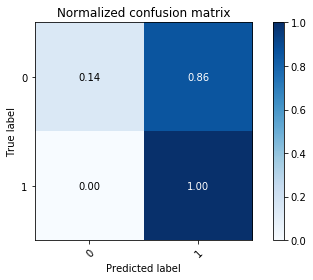

In [13]:
# Plot normalized confusion matrix
plot_confusion_matrix(np.argmax(class_test,axis=1), np.argmax(classes,axis=1), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Increasing the complexity of the architecture: VGG6

talk aout convolutional kernels in a CNN
<img src="figures/cnn-1.pdf">

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

import numpy as np
def vgg6(input_shape=(21, 21, 1), n_classes: int = 2):
    """
        VGG6
    :param input_shape:
    :param n_classes:
    :return:
    """

    model = tf.keras.models.Sequential(name='VGG6')
    # input: 21x21 images with 1 channel -> (21, 21, 1) tensors.
    # this applies 16 convolution filters of size 3x3 each.
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', name='conv2'))
    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_1'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv3'))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv4'))
    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu', name='fc_1'))
    model.add(tf.keras.layers.Dropout(0.5))
    # output layer
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))

    return model

In [15]:
#explain input shapes and why it is needed/important
#view a kernel filter - look for this
#explain dropouts
#why multiple batch normalization
# does the variation in the loss for the validation set tell me about the uncertainty in the classifier

In [ ]:
vgg_model = vgg6()
vgg_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
n_epochs=10
vgg_model.summary()
vgg_model_history = vgg_model.fit(data_train, class_train, epochs=n_epochs, batch_size=512, verbose=1, 
                                  validation_data=(data_val, class_val), shuffle=True)

Model: "VGG6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 19, 19, 16)        160       
_________________________________________________________________
conv2 (Conv2D)               (None, 17, 17, 16)        2320      
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 17, 17, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 16)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 16)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 6, 6, 32)          4640      
_________________________________________________________________
conv4 (Conv2D)               (None, 4, 4, 32)          9248   

In [ ]:
vgg_model.predict(data_test)

In [ ]:
model_history = vgg_model_history
import matplotlib.pyplot as plt
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
acc = model_history.history['acc']
val_acc = model_history.history['val_acc']
plt.figure()
plt.plot(np.arange(n_epochs), loss, label='Training Loss')
plt.plot(np.arange(n_epochs), val_loss, label='Validation Loss')
plt.title('Loss Curves')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.savefig('Keras_Loss.png')
plt.figure()
plt.plot(np.arange(n_epochs), acc, label='Training Accuracy')
plt.plot(np.arange(n_epochs), val_acc, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
classes = vgg_model.predict(data_test)
plt.hist(classes[:,1])
plt.title('Final Test Probabilities')
plt.xlabel('Probability of Real Object')
plt.ylabel('Stamp Counts')

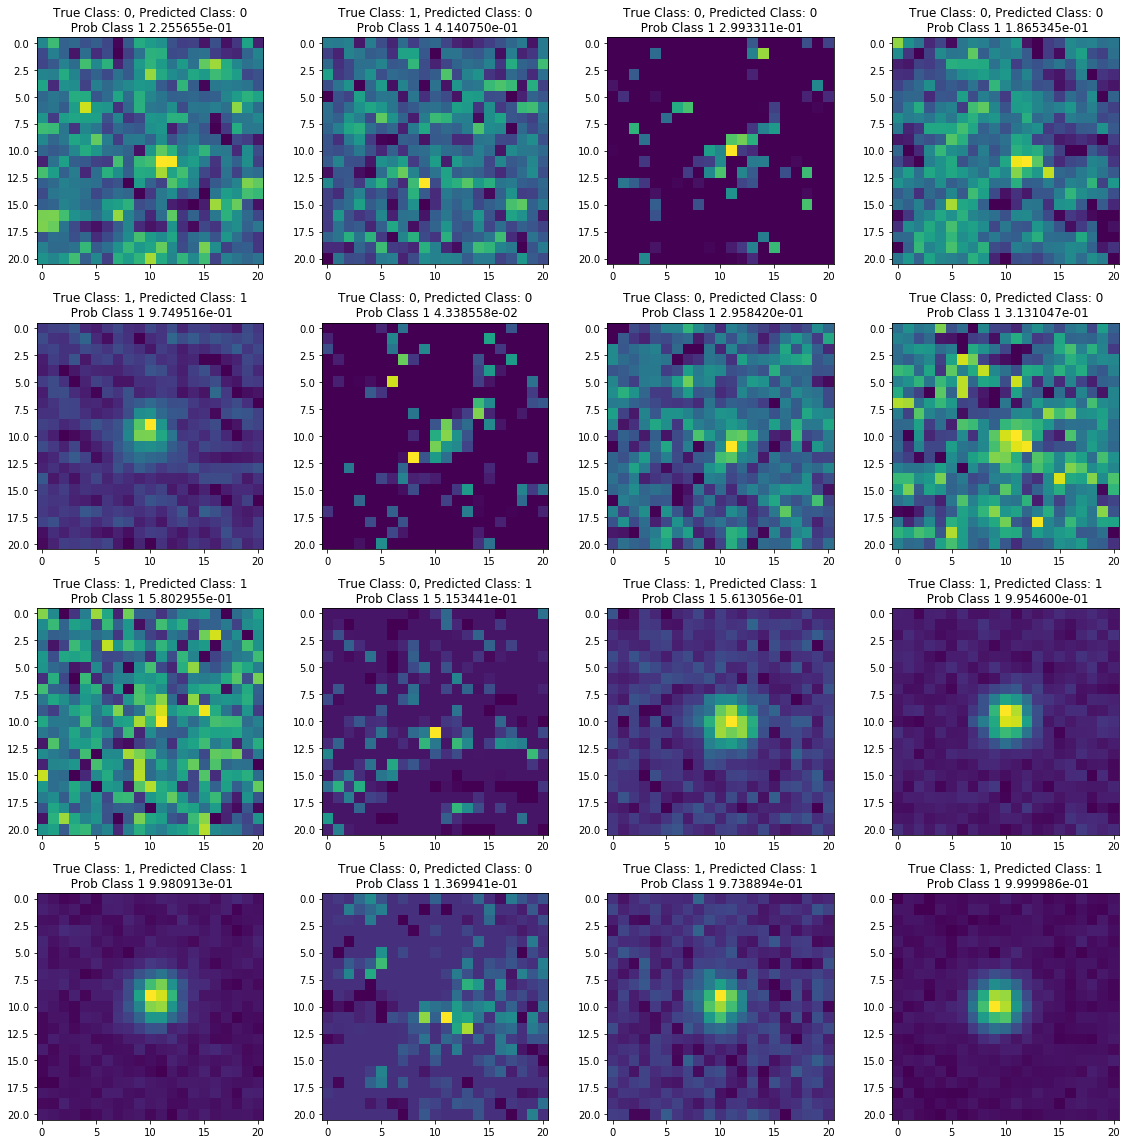

In [26]:
fig = plt.figure(figsize=(16, 16))
for i in range(16):
    fig.add_subplot(4,4,i+1)
    plt.imshow(data_test[i].reshape(21,21))
    plt.title('True Class: %i, Predicted Class: %i\n  Prob Class 1 %e ' % 
              (np.argmax(class_test[i]), np.argmax(classes[i]), classes[i,1]))
plt.tight_layout()

In [ ]:
#occlusion maps

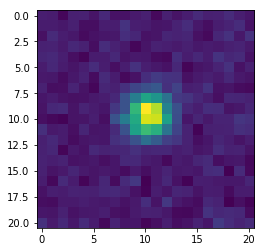

In [33]:
plt.imshow(data_test[11].reshape(21,21))

### Occulsion Maps

289


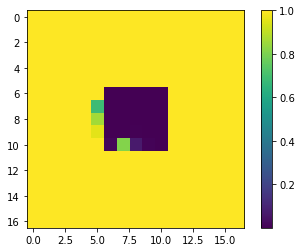

In [45]:
model = vgg_model
kernel_size=5
input_stamp = data_test[11].reshape(21,21)
i = 0
j=0
heatmap = []
keras_stamps = []
for j in range(22-kernel_size):
    for i in range(22-kernel_size):
        img = np.copy(input_stamp)
        img[i:i+kernel_size,j:j+kernel_size] = 0
        img = normalize_image(img)
        keras_stamps.append(img)
keras_stamps = np.array(keras_stamps).reshape([-1,21,21,1])
probs = model.predict(keras_stamps)
heatmap = probs[:,1]
plt.imshow(np.array(heatmap).reshape(22-kernel_size,22-kernel_size))
plt.colorbar()

### More complicated architectures: resnet50

In [ ]:
# Based on https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Networks_yourself.ipynb
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

def ResNet50(input_shape=(21, 21, 1), classes=2):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    #X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
resnet50_model = ResNet50()
resnet50_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
n_epochs=5
resnet_model_history = resnet50_model.fit(data_train, class_train, epochs=n_epochs, batch_size=256, verbose=1, 
                                          validation_data=(data_val, class_val), shuffle=True)